# Load data and prework

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import torch
from torch import nn
from torchvision import transforms
import albumentations as A
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.nn.functional as F
#!pip install -U git+https://github.com/albumentations-team/albumentations

# Pre-defined functions

These functions were supplied as part of the challenge.

In [2]:
def rle2mask(mask_rle, shape):
    """
    mask_rle: run-length as string formated (start length)ы
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if mask_rle != mask_rle:
        return np.zeros(shape)
    elif mask_rle == '':
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def out2rle(outputs):
    rles = []
    
    smooth = 1e-15
    try:
        prediction = outputs.detach().cpu().numpy()
    except:
        prediction = outputs
    for j, sample in enumerate(prediction):
        for val in range(0, 7):
            ch_pred = sample[val]
            rles.append(mask2rle(ch_pred.T > 0.5))
    return rles

In [3]:
class Dataset():
    def __init__(self, image_dir, train_meta, transform=None, train=True):
        self.image_dir = image_dir
        self.image_names = os.listdir(self.image_dir)
        self.train_meta = pd.read_csv(train_meta).drop_duplicates(['ImageId', 'ClassId']) if train_meta is not None else None
        self.transform = transform
        
        self.train = train

    def __getitem__(self, index):
        img_name = self.image_names[index]# ['ImageId']
        path = os.path.join(self.image_dir, img_name)

        img = cv2.imread(path)
        img_shape = (img.shape[0], img.shape[1])
        ce_mask = [
            (1) * rle2mask(rle, shape=(img.shape[1], img.shape[0]))[:, :, None] \
                for i, rle in enumerate(self.train_meta[self.train_meta['ImageId']==img_name]['EncodedPixels'])
        ] if self.train else None
        ce_mask = np.concatenate(ce_mask, -1) if self.train else None# np.sum(ce_mask, axis=0, dtype=np.float32)[:, :, None]
        if self.transform is not None:
            if self.train:
                img = self.transform(
                    image= (img),
                    mask= (ce_mask)
                )
            else:
                img = self.transform(
                    image= (img)
                )
        
        result = {
            'image_shape': torch.tensor(img_shape),
            'image_name': img_name,
            'image': torch.tensor(img['image']).transpose(-1, 0).transpose(-1, -2).float(), 
            'mask': torch.tensor(img['mask']).transpose(-1, 0).transpose(-1, -2).float() if self.train else []
        }
        
        return result
    
    def __len__(self, ):
        return len(self.image_names)

# Preprocessing

Preprocessing the image data and applying image transformations using the albumentations library. Adding different transformations and distortions to the images led to better results.



In [5]:
img_size = 384

train_transforms = A.Compose([
    A.PadIfNeeded(img_size, img_size),
    A.RandomCrop(img_size, img_size),
    A.OneOf([        
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
    ]),
    A.OneOf([
        A.ElasticTransform(p=0.3, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.3),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.6),        
        ], p=0.4),
    A.CLAHE(p=0.4),
    A.RandomBrightnessContrast(p=0.4),    
    A.RandomGamma(p=0.4),
    A.GridDropout(p=0.2),
    A.Normalize(
        mean=(0.502, 0.502, 0.502),
        std=(0.09, 0.09, 0.09)),
])

test_transforms = A.Compose([
    A.PadIfNeeded(384, 384),
    A.Resize(384, 384),
    A.Normalize(
        mean=(0.502, 0.502, 0.502),
        std=(0.09, 0.09, 0.09)),
])

In [6]:
train_val_dataset = Dataset(
    image_dir='', 
    train_meta='',
    transform=train_transforms
)

# Model
The model is a full fledged U-Net. Different experiments with hyperparameters, Dropout and Batch-/Layernorm led to the model as it is now.

In [7]:
class UNet(nn.Module):
    #Build Building Blocks of model
    def encoder_block(self, in_channels, out_channels, kernel_size = 3):
        block = nn.Sequential(
            nn.Conv2d(kernel_size=kernel_size, in_channels = in_channels, out_channels = out_channels, padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(kernel_size=kernel_size, in_channels = out_channels, out_channels = out_channels, padding = 'same'),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels)
        )
        return block
    
    def max_pool_dropout(self, kernel_size = 2, dropout_rate = 0.1):
        block = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(dropout_rate)
        )
        return block
    
    def decoder_block(self, in_channels, mid_channel, out_channels, kernel_size=3, dropout_rate=0.1):
        block = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Conv2d(kernel_size=kernel_size, in_channels = in_channels, out_channels = mid_channel, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(mid_channel),
            nn.Conv2d(kernel_size=kernel_size, in_channels = mid_channel, out_channels = mid_channel, padding = "same"),
            nn.ReLU(),
            nn.BatchNorm2d(mid_channel),
            nn.ConvTranspose2d(in_channels = mid_channel, out_channels = out_channels, kernel_size=3,
                              stride = 2, padding = 1, output_padding = 1)        
        )
        return block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3, dropout_rate=0.1):
        block=nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Conv2d(kernel_size=kernel_size, in_channels = in_channels, out_channels = mid_channel, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(mid_channel),
            nn.Conv2d(kernel_size=kernel_size, in_channels = mid_channel, out_channels = mid_channel, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(mid_channel),
            nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
        return block
    
    #Initialize Model
    def __init__(self, in_channel, out_channel, dropout_rate):
        super(UNet, self).__init__()
        #Parameters
        self.dropout_rate = dropout_rate
               
        #Encoder part
        self.conv_encoder1 = self.encoder_block(in_channels = in_channel, out_channels = 64)
        self.encoder_pool1 = self.max_pool_dropout(dropout_rate = self.dropout_rate)
        self.conv_encoder2 = self.encoder_block(64, 128)
        self.encoder_pool2 = self.max_pool_dropout(dropout_rate = self.dropout_rate)
        self.conv_encoder3 = self.encoder_block(128,256)
        self.encoder_pool3 = self.max_pool_dropout(dropout_rate = self.dropout_rate)
        self.conv_encoder4 = self.encoder_block(256,512)
        self.encoder_pool4 = self.max_pool_dropout(dropout_rate = self.dropout_rate)
        
        #Middle part
        self.middle_part = nn.Sequential(
            nn.Conv2d(kernel_size = 3, in_channels = 512, out_channels = 1024, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(kernel_size = 3, in_channels = 1024, out_channels = 1024, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 3,
                              stride = 2, padding = 1, output_padding = 1)        
        )
        
        #Decoder part
        self.conv_decoder3 = self.decoder_block(1024,512,256)
        self.conv_decoder2 = self.decoder_block(512,256,128)
        self.conv_decoder1 = self.decoder_block(256,128,64)
        self.final_layer = self.final_block(128,64,out_channel)
        
        
    #Forward pass
    def forward(self, x):
        #Encoder
        encoder_block1 = self.conv_encoder1(x)
        encoder_pool1 = self.encoder_pool1(encoder_block1)
        encoder_block2 = self.conv_encoder2(encoder_pool1)
        encoder_pool2 = self.encoder_pool2(encoder_block2)
        encoder_block3 = self.conv_encoder3(encoder_pool2)
        encoder_pool3 = self.encoder_pool3(encoder_block3)
        encoder_block4 = self.conv_encoder4(encoder_pool3)
        encoder_pool4 = self.encoder_pool4(encoder_block4)
        #Middle part
        middle_part = self.middle_part(encoder_pool4)
        #Decoder
        concat1 = torch.cat((middle_part, encoder_block4), dim = 1)
        decoder_block3 = self.conv_decoder3(concat1)
        concat2 = torch.cat((decoder_block3, encoder_block3), dim = 1)
        decoder_block2 = self.conv_decoder2(concat2)
        concat3 = torch.cat((decoder_block2, encoder_block2), dim = 1)
        decoder_block1 = self.conv_decoder1(concat3)
        concat4 = torch.cat((decoder_block1, encoder_block1), dim = 1)
        #Final layer
        final_layer = self.final_layer(concat4)
        return final_layer

## Define Loss
 
For my loss function I use a linear combination of the Dice- and the Jaccard loss.

In [8]:
class DiceLoss(torch.nn.Module):
    def __init__(self, device):
        super(DiceLoss, self).__init__()
    
    def forward(self, outputs, masks):
        smooth = 1e-15
        prediction = outputs.softmax(dim=1)

        dice_loss = None

        for val in range(0, 7):
            ch_pred = prediction[:, val]
            # ch_pred = ch_pred / (ch_pred + 1e-10)

            intersection = torch.sum(ch_pred * masks[:, val], dim=(1,2))
            union = torch.sum(ch_pred, dim=(1,2)) + torch.sum(masks[:, val], dim=(1,2))      
            dice_part = (1 - (2 * intersection + smooth) / (union + smooth)).abs()
            dice_loss = dice_part if dice_loss is None else dice_loss + dice_part
            
        return dice_loss / 7

In [9]:
class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(JaccardLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

# Training process

In [10]:
#Define training parameters
val_split = 0.1
batch_size = 8
batch_size_test = 6
learning_rate = 0.0005
dropout_rate = 0.1
epochs = 10

## Validation split and data Loaders

In [11]:
val_length = int(np.round(len(train_val_dataset)*val_split))
val_dataset, train_dataset = random_split(train_val_dataset, lengths = [val_length, len(train_val_dataset)-val_length], generator=torch.Generator().manual_seed(42))

In [12]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, 
    shuffle=True, 
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, 
    shuffle=False, 
)

## Define Optimizer and Hyperparameters

In [13]:
unet = UNet(in_channel = 3, out_channel = 7, dropout_rate = dropout_rate).cuda()

In [14]:
opt = torch.optim.AdamW(unet.parameters(), lr = learning_rate)
loss_f = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda().reshape(1, 7, 1, 1))
loss_j = JaccardLoss('cuda:0')
loss_d = DiceLoss('cuda:0')

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience = 5, verbose = True)

## Actual training process

In [15]:
model = "unet"
try:    
    checkpoint_path = "".format(model)
    checkpoint = torch.load(checkpoint_path)
    unet.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']+1
    loss = checkpoint['loss']
    print("Model restored")
except:
    last_epoch = 0
    print("No Model loaded")

Model restored


In [ ]:
running_loss = 0

for epoch in range(last_epoch+1, last_epoch+epochs+1):
    #Training
    unet.train()
    for i, sample in enumerate(train_loader):
        opt.zero_grad()
        predict = unet(sample["image"].cuda().detach())
        train_loss = 0.4*loss_f(predict, sample["mask"].cuda().detach()) + 0.6*loss_j(predict, sample["mask"].cuda().detach()).mean()
        train_loss.backward()        
        opt.step()        
        
        #Writing to tensorboard
        running_loss += train_loss.item()
        if i % 30 == 29:            
            writer.add_scalar('training loss',
                running_loss / 30,
                epoch * len(train_loader) + i)
        running_loss = 0
            
    #Validation
    unet.eval()
    for i, sample in enumerate(val_loader):
        with torch.no_grad():
            predict = unet(sample["image"].cuda().detach())
        val_loss = loss_d(predict, sample["mask"].cuda().detach()).mean()
        
    #Write to learning rate scheduler
    scheduler.step(val_loss)
        
    #Writing to tensorboard      
    writer.add_scalar('validation loss', val_loss, (epoch+1) * len(train_loader))
    
    #Save image prediction
    writer.add_figure('predictions vs. actuals',
                            get_images(sample,predict),
                            global_step = (epoch+1) * len(train_loader))
    
    #Print loss
    print('Epoch: {} \t Train_Loss: {} \t Val_Loss: {}'.format((epoch+1), round(train_loss.item(),4), round(val_loss.item(),4)))
    
    #Save model every 5th epoch
    if (epoch+1)%5==0:
        torch.save({
                'epoch': epoch,
                'model_state_dict': unet.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': val_loss,
                }, checkpoint_path)
        print("Checkpoint saved")

In [ ]:
torch.save({
        'epoch': epoch,
        'model_state_dict': unet.state_dict(),
        'optimizer_state_dict': opt.state_dict(),
        'loss': val_loss,
        }, checkpoint_path)

# Results

Prediction of validation images

In [20]:
def get_images(sample,predict):
    channel = np.random.randint(7)
    fig = plt.figure(figsize = (15,8))
    ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])    
    plt.imshow(sample["image"][0][2], cmap = "gray")
    ax.set_title("Input image")
    ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    plt.imshow(sample["mask"][0][channel].cpu().detach())
    ax.set_title("True Mask")
    ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    plt.imshow(predict[0][channel].cpu().detach())
    ax.set_title("Prediction")

In [17]:
for image in val_loader:
    break
pred = unet(image["image"].cuda())

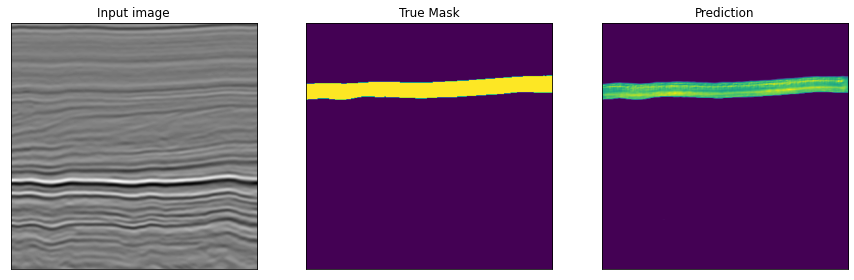

In [21]:
get_images(image,pred)